# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

features, target = next(train_gen_flow)
sns.set(color_codes=True)

Found 7591 validated image filenames.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


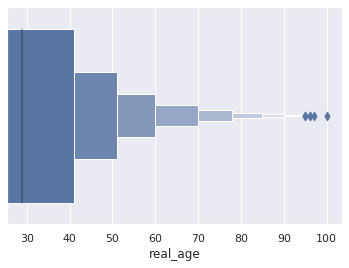

In [2]:
ax=sns.boxenplot(labels['real_age'])

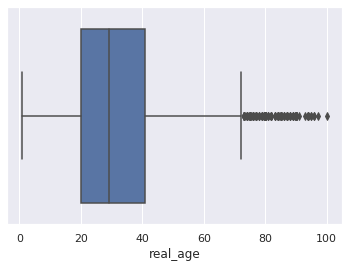

In [4]:
ax1=sns.boxplot(labels['real_age'])

большая часть в выборке люди от 20 до 40, 70+ выбросы, можно было бы их отрезать, однако метрика mae, которую мы используем, более устойчива к выбросам.

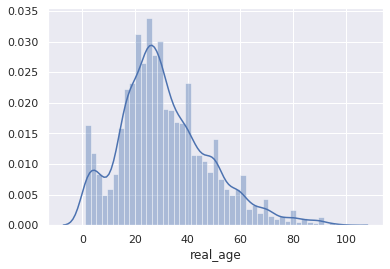

In [2]:
sns.distplot(labels['real_age'])

<font color='blue'>добавил гистограмму, по ней распределение видно лучше, появился "горб" с школьниками.<br> 

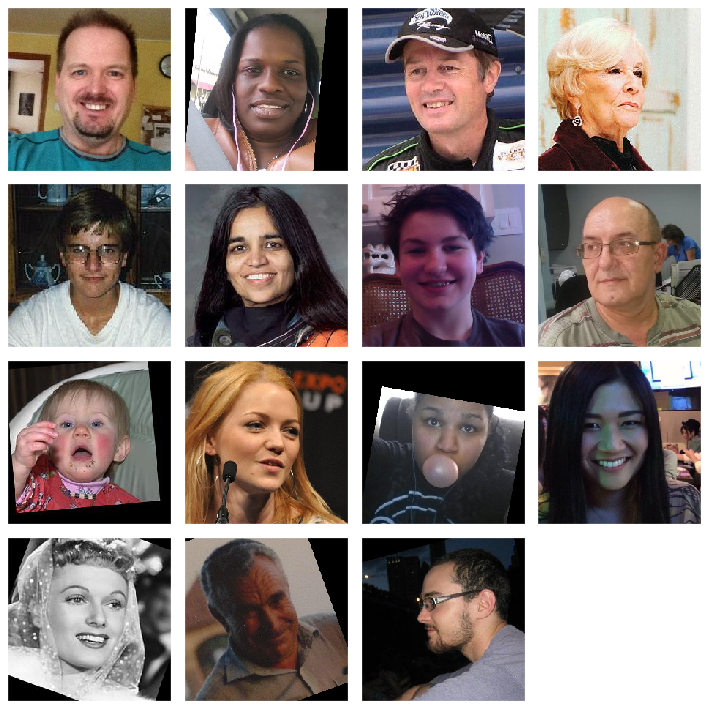

In [3]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Качество фото которые я вывел на экран не удовлетворительное, некоторые фото имеют очень плохое разрешение, некотрые фото имеют наклон. Так же все фотограции находятся в различном цветовом диапазоне, 1 фото вообще черно- белое. я считаю что в совокупности все это негативно скажется на качестве модели. Возможно пердварительно все фотографии тренировочной выборки надо как то унифицировать, после чего применять аугментации, цвета, поворота, яркости, что бы модель могла давать правильные ответы на не обработаных фотографиях тестевой выборки

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1/255.
                                       ,horizontal_flip = True)                                                              
    
    train_datagen_flow = train_datagen.flow_from_dataframe( dataframe = labels, directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(150, 150),
        batch_size=32,
        subset = 'training',
        class_mode='raw',
        seed=12345)
    return train_datagen_flow
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1/255.
                                   
                                      )
    test_datagen_flow = test_datagen.flow_from_dataframe( dataframe = labels, directory = path + 'final_files/',
            x_col = 'file_name',
            y_col = 'real_age',
            target_size=(150, 150),
            batch_size=32,
            subset = 'validation',
            class_mode='raw',
            seed=12345)
    return test_datagen_flow
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape = input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):                        
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```





Train for 178 steps, validate for 60 steps

Epoch 1/5

2020-07-08 06:06:58.446151: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2020-07-08 06:07:02.715241: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

178/178 - 112s - loss: 268.7650 - mae: 11.7871 - val_loss: 711.8607 - val_mae: 21.7402

Epoch 2/5

178/178 - 39s - loss: 84.8934 - mae: 6.9025 - val_loss: 569.6659 - val_mae: 18.7921

Epoch 3/5

178/178 - 38s - loss: 52.0270 - mae: 5.4914 - val_loss: 308.8320 - val_mae: 13.0135

Epoch 4/5

178/178 - 39s - loss: 37.8963 - mae: 4.6963 - val_loss: 126.9145 - val_mae: 8.4907

Epoch 5/5

178/178 - 42s - loss: 28.4195 - mae: 4.0319 - val_loss: 81.5219 - val_mae: 6.7511

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

60/60 - 10s - loss: 81.5219 - mae: 6.7511


```

# 3. Анализ обученной модели

При сравнении с моделью на классификацию, которую мы строили в тренажере, наша модель учится гораздо быстрее на 5 эпох ушло не более 5 минут.

Значение метрики MAE я получил 6.7, что не дотягивает до эталонных 5.4 но все же показывает что наша модель довольно хорошо может угадывать возраст человека